# Cars detection
This project aims to detect cars in images.

The steps of this project is as following
* Create features vector for the training set and the test set.
* Train an SVM classifier on the best parameters using Grid Search.
* Search in images using sliding windows.
* Filter the positives using heat map, and identify findings using it.

## Features Vector
In order to classify images, we need to identify the features for the training set. The features will be used are the following.

1. The HOG vector.
2. A smaller flattened version of the image.

The rest of the documentation can be found in the writeup file.


In [1]:
# Helper functions
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import glob
import pickle
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label

In [35]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    bboxes = []
    #img = img#.astype(np.float32)#/255
    ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    img_tosearch = ctrans_tosearch[ystart:ystop,:,:]
    
    #img_tosearch = ctrans_tosearch
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
        
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    #print(window)
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1


    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

    return draw_img, bboxes


def extract_features_for_image(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    #features = []
    # Iterate through the list of images
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    #features.append(hog_features)
    # Return list of feature vectors
    return hog_features

In [29]:
#get_hog_features(img, orient, pix_per_cell, cell_per_block, 
#                        vis=False, feature_vec=True):

orientations = 9
pix_per_cell = 8
cell_per_block = 2


In [ ]:

notcars = glob.glob('data\\non-vehicles/*/*.png')
cars = glob.glob('data\\vehicles/*/*.png')

print(len(notcars))
print(len(cars))

In [ ]:
def extractImageData(imgPath):
    #convert_color(img, conv='RGB2YCrCb')
    trainImage = cv2.cvtColor(cv2.imread(imgPath,1),cv2.COLOR_BGR2YCrCb)
    bs = bin_spatial(trainImage)
    #ch = color_hist(trainImage)
    hogf = extract_features_for_image(trainImage, cspace='RGB', orient=orientations,
                                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                     hog_channel='ALL')
    #return np.hstack([bs,ch,hogf])
    return np.hstack([bs,hogf])

In [ ]:
notcars_data = np.array([extractImageData(pth) for pth in notcars], dtype='float64')
print(notcars_data.shape)

In [ ]:
cars_data = np.array([extractImageData(pth) for pth in cars], dtype='float64')
print(cars_data.shape)

In [ ]:
pickle.dump({'cars':cars_data,'notcars':notcars_data}, open('data_lists_noHist.p', 'wb'))

In [ ]:
labels = np.concatenate([np.ones(len(cars_data)), np.zeros(len(notcars_data))]).astype('float64')
data = np.vstack([cars_data, notcars_data])

In [ ]:
data, labels = shuffle(data, labels)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(data, labels)

In [ ]:

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
parameters = {'C':[1, 10, 100]}
svr = LinearSVC(verbose=100)
clf = GridSearchCV(svr, parameters, n_jobs=4,verbose=100)
clf.fit(X_train_scaled, y_train)


In [ ]:
clf.score(X_test_scaled, y_test)

In [40]:
imgPath = 'test_images\\test1.jpg'
tstImg = cv2.cvtColor(cv2.imread(imgPath,1),cv2.COLOR_BGR2RGB)
ystart = 400
ystop = 656 
scale = 2
bboxess = []
for scale in [.7,.9,1,1.2,1.5,1.7,2]:
    bboxess += find_cars(tstImg, ystart, ystop, scale, clf, X_scaler, orientations, pix_per_cell, cell_per_block)[1]
#plt.imshow(output)

In [41]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    #return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    #return heatmap



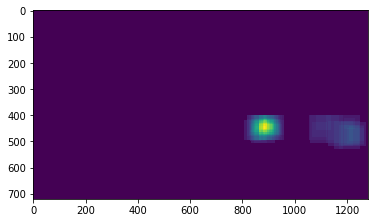

In [42]:
heatmap = np.zeros_like(output[:,:,1])
add_heat(heatmap, bboxess)
plt.imshow(heatmap)
apply_threshold(heatmap, 2)
plt.Figure()
plt.imshow(heatmap)

In [43]:

labels = label(heatmap)
print(labels)

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 2)


In [44]:

print(labels[1], 'cars found')

2 cars found


In [45]:


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


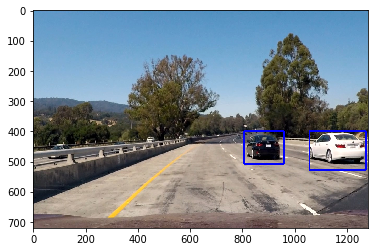

In [46]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(tstImg), labels)
# Display the image
plt.imshow(draw_img, aspect='auto')

In [71]:
def pipelineFindCars(imageRGB):
    bboxess = []
    for scale in [.9,1,1.2,1.5,1.7]:
        output, bboxes = find_cars(imageRGB, ystart, ystop, scale, clf, X_scaler, orientations, pix_per_cell, cell_per_block)
        bboxess += bboxes
    #output, bboxess = find_cars(imageRGB, ystart, ystop, scale, clf, X_scaler, orientations, pix_per_cell, cell_per_block)
    heatmap = np.zeros_like(output[:,:,1])
    add_heat(heatmap, bboxess)
    apply_threshold(heatmap, 2)
    labels = label(heatmap)
    return draw_labeled_bboxes(np.copy(imageRGB), labels)

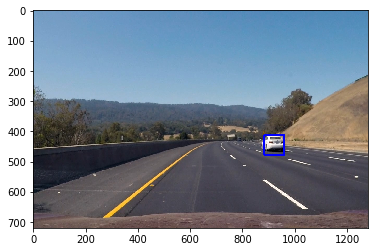

In [67]:
imgPath = 'test_images\\test3.jpg'
tstImg = cv2.cvtColor(cv2.imread(imgPath,1),cv2.COLOR_BGR2RGB)
draw_img = pipelineFindCars(tstImg)
plt.imshow(draw_img, aspect='auto')

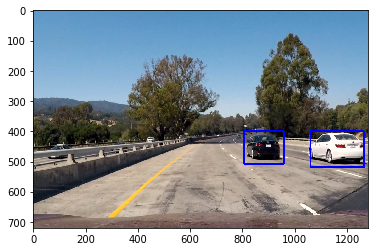

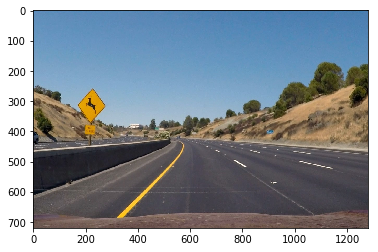

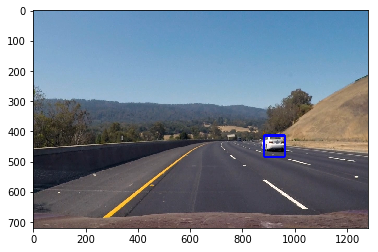

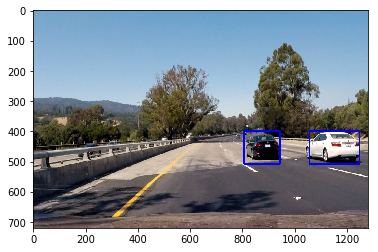

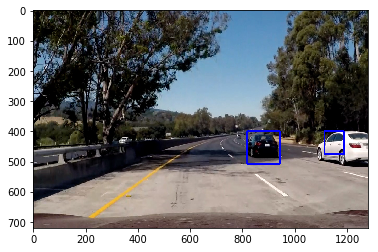

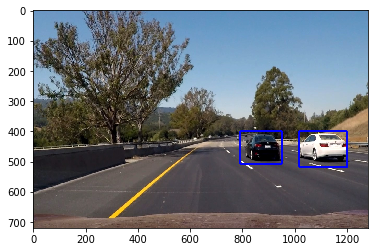

In [72]:
testimages = glob.glob('test_images/test*.jpg')
for imgPath in testimages:
    #imgPath = 'test_images\\test3.jpg'
    tstImg = cv2.cvtColor(cv2.imread(imgPath,1),cv2.COLOR_BGR2RGB)
    draw_img = pipelineFindCars(tstImg)
    plt.figure()
    plt.imshow(draw_img, aspect='auto')

In [73]:
# Create a video
white_output = 'output1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipelineFindCars)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output1.mp4
[MoviePy] Writing video output1.mp4



  5%|████▏                                                                         | 67/1261 [06:54<2:00:55,  6.08s/it]


 11%|████████▏                                                                    | 135/1261 [13:52<1:55:16,  6.14s/it]


 16%|████████████▍                                                                | 203/1261 [21:02<1:51:40,  6.33s/it]


 21%|████████████████▌                                                            | 271/1261 [28:12<1:43:49,  6.29s/it]


 27%|████████████████████▋                                                        | 339/1261 [35:23<1:35:45,  6.23s/it]


 32%|████████████████████████▊                                                    | 407/1261 [42:35<1:30:20,  6.35s/it]


 38%|█████████████████████████████                                                | 475/1261 [49:44<1:22:08,  6.27s/it]


 43%|█████████████████████████████████▏                                           | 543/1261 [56:55<1:15:25,  6.30s/it]


 48%|████████████████████████████████████▎                                      | 611/1261 [1:04:29<1:12:16,  6.67s/it]


 54%|████████████████████████████████████████▍                                  | 679/1261 [1:11:56<1:02:47,  6.47s/it]


 59%|█████████████████████████████████████████████▌                               | 747/1261 [1:19:17<55:47,  6.51s/it]


 65%|█████████████████████████████████████████████████▊                           | 815/1261 [1:26:49<46:57,  6.32s/it]


 70%|█████████████████████████████████████████████████████▉                       | 883/1261 [1:34:04<39:59,  6.35s/it]


 75%|██████████████████████████████████████████████████████████                   | 951/1261 [1:41:21<33:13,  6.43s/it]


 81%|█████████████████████████████████████████████████████████████▍              | 1019/1261 [1:48:42<26:15,  6.51s/it]


 86%|█████████████████████████████████████████████████████████████████▌          | 1087/1261 [1:56:01<18:49,  6.49s/it]


 92%|█████████████████████████████████████████████████████████████████████▌      | 1155/1261 [2:03:20<11:17,  6.39s/it]


 97%|█████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [2:10:36<04:04,  6.43s/it]


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [2:14:34<00:06,  6.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1.mp4 

Wall time: 2h 14min 37s


In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [57]:
clip1.reader.close()
clip1.audio.reader.close_proc()

In [ ]:
d = {'clf': clf, 'X_scaler': X_scaler}
pickle.dump(d, open('clf-YCrCb-nohist.p', 'wb'))

In [7]:

e = pickle.load(open('clf-YCrCb-nohist.p', 'rb'))

In [8]:
clf = e['clf']
X_scaler = e['X_scaler']